Import et préparation du dataset

In [31]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Fixer la seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Charger le dataset
file_path = '/content/drive/MyDrive/dataset (1).txt'
data = pd.read_csv(file_path, header=None)
print("Taille dataset :", data.shape)

# Séparation features / labels
X = data.iloc[:, :-1].values.astype(float)
y_raw = data.iloc[:, -1].values.astype(str)

# Encodage labels → int → one-hot
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(y_int.reshape(-1,1))

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y_int
)

print("Train:", X_train_full.shape, "Test:", X_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Taille dataset : (5600, 32)
Train: (4480, 31) Test: (1120, 31)


Définition du modèle MLP

In [32]:
def build_model(input_dim, output_dim, hidden_units=128, dropout_rate=0.2):
    """
    input_dim : nombre de features
    output_dim : nombre de classes
    hidden_units : neurones par couche cachée
    dropout_rate : régularisation
    """
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(hidden_units, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def evaluate_model_keras(model, X, y):
    loss, acc = model.evaluate(X, y, verbose=0)
    return loss, acc

def predict_proba(model, X, batch_size=256):
    return model.predict(X, verbose=0, batch_size=batch_size)


Stratégies Active Learning existantes

In [33]:
def query_least_confidence(probs, k):
    uncertainty = 1 - np.max(probs, axis=1)
    return np.argsort(uncertainty)[-k:]

def query_margin(probs, k):
    top_sorted = np.sort(probs, axis=1)
    margin = top_sorted[:, -1] - top_sorted[:, -2]
    return np.argsort(margin)[:k]

def query_entropy(probs, k):
    entropy = -np.sum(probs * np.log(probs + 1e-12), axis=1)
    return np.argsort(entropy)[-k:]

def query_random(probs, k):
    return np.random.choice(len(probs), size=k, replace=False)


Stratégie Query-by-Committee

In [34]:
def query_committee(committee_models, X_unlabeled, k):

    all_probs = np.array([predict_proba(m, X_unlabeled) for m in committee_models])
    avg_probs = np.mean(all_probs, axis=0)
    entropy = -np.sum(avg_probs * np.log(avg_probs + 1e-12), axis=1)
    return np.argsort(entropy)[-k:]


Boucle Active Learning principale

In [35]:
def run_active_learning(X_pool, y_pool, X_test, y_test,
                        initial_size=200, query_size=200, steps=10,
                        strategy='least_confidence', epochs_per_step=20,
                        batch_size=64, verbose=0, committee_size=3):

    input_dim = X_pool.shape[1]
    output_dim = y_pool.shape[1]

    idxs = np.arange(len(X_pool))
    np.random.shuffle(idxs)
    X_shuf, y_shuf = X_pool[idxs], y_pool[idxs]

    X_labeled = X_shuf[:initial_size]
    y_labeled = y_shuf[:initial_size]
    X_unlabeled = X_shuf[initial_size:]
    y_unlabeled = y_shuf[initial_size:]

    history = []

    for step in range(steps):

        if strategy == 'committee':
            # Crée un ensemble de modèles
            committee_models = [build_model(input_dim, output_dim) for _ in range(committee_size)]
            for m in committee_models:
                m.fit(X_labeled, y_labeled, epochs=epochs_per_step, batch_size=batch_size, verbose=0)
            query_idx = query_committee(committee_models, X_unlabeled, min(query_size, len(X_unlabeled)))

            train_acc = np.mean([evaluate_model_keras(m, X_labeled, y_labeled)[1] for m in committee_models])
            train_loss = np.mean([evaluate_model_keras(m, X_labeled, y_labeled)[0] for m in committee_models])
            test_acc = np.mean([evaluate_model_keras(m, X_test, y_test)[1] for m in committee_models])
            test_loss = np.mean([evaluate_model_keras(m, X_test, y_test)[0] for m in committee_models])

        else:
            model = build_model(input_dim, output_dim)
            model.fit(X_labeled, y_labeled, epochs=epochs_per_step, batch_size=batch_size, verbose=verbose)
            probs = predict_proba(model, X_unlabeled)

            if strategy == 'least_confidence':
                query_idx = query_least_confidence(probs, min(query_size, len(X_unlabeled)))
            elif strategy == 'margin':
                query_idx = query_margin(probs, min(query_size, len(X_unlabeled)))
            elif strategy == 'entropy':
                query_idx = query_entropy(probs, min(query_size, len(X_unlabeled)))
            elif strategy == 'random':
                query_idx = query_random(probs, min(query_size, len(X_unlabeled)))
            else:
                raise ValueError("Unknown strategy")

            train_loss, train_acc = evaluate_model_keras(model, X_labeled, y_labeled)
            test_loss, test_acc = evaluate_model_keras(model, X_test, y_test)

        # Mise à jour des sets
        X_new = X_unlabeled[query_idx]
        y_new = y_unlabeled[query_idx]
        X_labeled = np.concatenate([X_labeled, X_new], axis=0)
        y_labeled = np.concatenate([y_labeled, y_new], axis=0)

        mask = np.ones(len(X_unlabeled), dtype=bool)
        mask[query_idx] = False
        X_unlabeled = X_unlabeled[mask]
        y_unlabeled = y_unlabeled[mask]

        history.append({
            'step': step+1,
            'num_labeled': len(X_labeled),
            'train_acc': train_acc,
            'train_loss': train_loss,
            'test_acc': test_acc,
            'test_loss': test_loss
        })

        if verbose:
            print(f"Step {step+1} — Labeled: {len(X_labeled)} — "
                  f"Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}")

        if len(X_unlabeled) == 0:
            break

    return history


Exécution et affichage des résultats


=== Strategy: random ===
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0547 - loss: 3.3883
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0971 - loss: 3.1470
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1724 - loss: 3.0223
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2796 - loss: 2.8416
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2954 - loss: 2.6908 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3370 - loss: 2.5480
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3907 - loss: 2.4242
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3923 - loss: 2.2377
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4370 - loss: 2.0881
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4753 - loss: 1.9445
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5539 - loss: 1.7727
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6385 - loss: 1.5783
Epoch 13/20

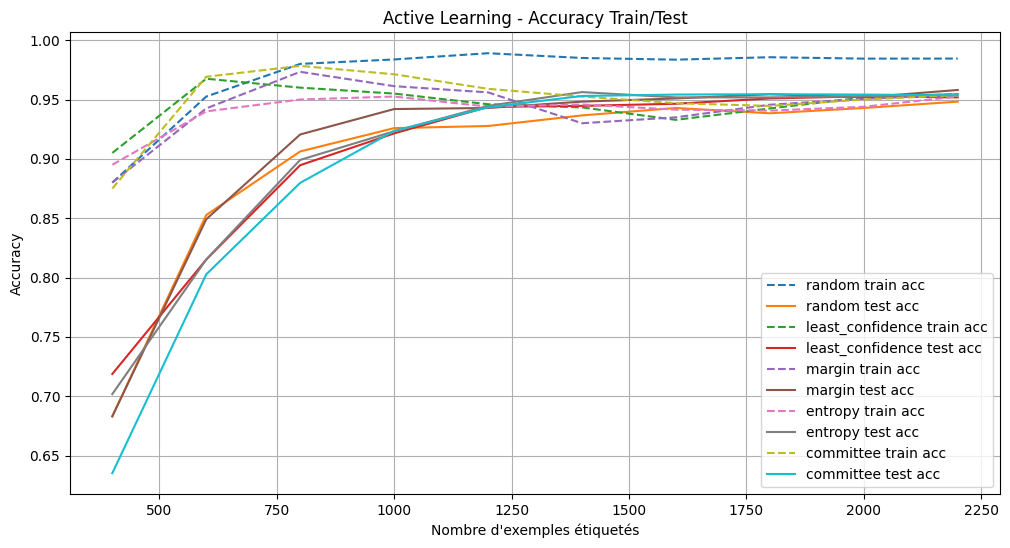

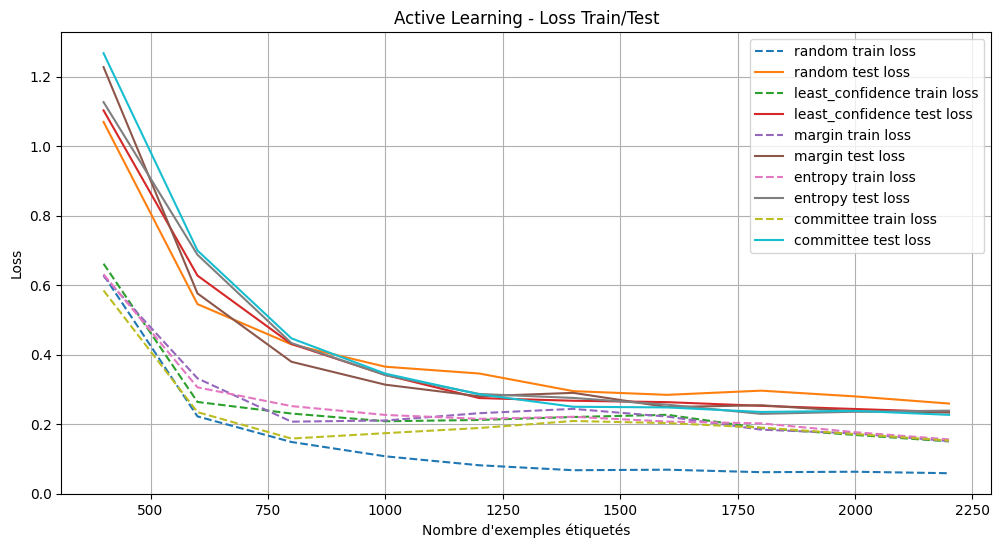

In [36]:
import matplotlib.pyplot as plt

strategies = ['random', 'least_confidence', 'margin', 'entropy', 'committee']
results = {}

for strat in strategies:
    print(f"\n=== Strategy: {strat} ===")
    history = run_active_learning(X_train_full, y_train_full, X_test, y_test,
                                  initial_size=200, query_size=200, steps=10,
                                  strategy=strat, epochs_per_step=20, verbose=1,
                                  committee_size=3)
    results[strat] = history

# Accuracy
plt.figure(figsize=(12,6))
for strat, hist in results.items():
    steps = [h['num_labeled'] for h in hist]
    train_acc = [h['train_acc'] for h in hist]
    test_acc = [h['test_acc'] for h in hist]
    plt.plot(steps, train_acc, '--', label=f'{strat} train acc')
    plt.plot(steps, test_acc, '-', label=f'{strat} test acc')
plt.xlabel("Nombre d'exemples étiquetés")
plt.ylabel("Accuracy")
plt.title("Active Learning - Accuracy Train/Test")
plt.grid(True)
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12,6))
for strat, hist in results.items():
    steps = [h['num_labeled'] for h in hist]
    train_loss = [h['train_loss'] for h in hist]
    test_loss = [h['test_loss'] for h in hist]
    plt.plot(steps, train_loss, '--', label=f'{strat} train loss')
    plt.plot(steps, test_loss, '-', label=f'{strat} test loss')
plt.xlabel("Nombre d'exemples étiquetés")
plt.ylabel("Loss")
plt.title("Active Learning - Loss Train/Test")
plt.grid(True)
plt.legend()
plt.show()
